In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
G = 4*np.pi**2

import batman
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import sklearn as sklearn
from sklearn.model_selection import train_test_split

In [3]:
#DATA GENERATION CELL

#This cell uses batman to model stellar transits with nonlinear limb darkening
#10,000 random planets are generated, and transits are simulated using batman
#The resulting light curves are a time-series of 500 flux measurements as the plannet passes in front of the star
#Random gaussian errors are added to each flux point in the light curve to simulate noise
#The true light curves (no noise) are also saved for evaluation and visualization purposes

is_transit = [] #Each entry corresponds to a light curve. 1 means the data contains a transit, 0 means no transit

#lists of true parameters for each light curve
a_list = [] #semimajor axis in stellar radii
Mstar_list = [] #Mass of the host star
e_list = [] #eccentricity of the orbit
i_list = [] #inclination of the orbit: 90 degrees means the transit is edge-on
R_list = [] #planet radius in units of stellar radii

#######################
#ADJUST PARAMETERS HERE
#######################
lightcurves = [] #The simulated light curves. This is what the NN is trained on
true_lightcurves = [] #The noise-free light curves

radius_max = 0.15 #max planet/star radius ratio
radius_min = 0.05 #min planet/star radius ratio

a_max = 200 #max semimajor axis in stellar radii
a_min = 2 #min semimajor axis in stellar radii (DO NOT GO BELOW 1)

e_max = 0.3 #max eccentricity
e_min = 0 #min eccentricity

w_max = 360 #max argument of perihelion
w_min= 0 #min argument of perihelion

N_transits = 10000 #number of transits to generate
noise_scale = 0.005 #scale of the noise, relative to the flux of the star

for n in range(N_transits):
    #Generate a random planet from the ranges below
    params = batman.TransitParams()
    Mstar = 1-0.9*np.random.rand() #Stellar mass, between 0.1 and 1 solar masses (this doesn't really matter)
    a = a_min + (a_max-a_min)*np.random.rand() #semi-major axis
    e = e_min + (e_max-e_min)*np.random.rand() #eccentricity
    i = 90 - np.arcsin(1/(a*(1+e)))*180/np.pi*np.random.rand() #inclination, so that the planet always transits
    R = radius_min + (radius_max-radius_min)*np.random.rand() #planet radius (in stellar radii units)
    w = w_min + (w_max - w_min)*np.random.rand() #argument of perihelion
    
    #calculate how long we need to observe to see the whole transit
    period = 2*np.pi*np.sqrt(a**3 / (G*Mstar))
    duration = 2 / (2*np.pi*a) * period
    
    #The duration of the observation is random between 2 and 6 times the transit length
    #This is so that the transits are not always the same number of points in length in the data
    #This will challenge the NN more
    obs_dur = 2 + 4*np.random.rand()#duration of observations compared to transit duration
    
    #offset the time of the transit, so the transit isn't always right in the middle of the data
    offset = 0.5-np.random.rand()
    times = np.linspace(-obs_dur*duration*(1/2), obs_dur*duration*(1/2), 500) + obs_dur*duration*offset
    
    #set model parameters
    params.t0 = 0
    params.per = period
    params.rp = R
    params.a = a
    params.inc = i
    params.ecc = e
    params.w = w
    params.limb_dark = "nonlinear"
    params.u = [0.5, 0.1, 0.1, -0.1]
    m = batman.TransitModel(params, times)
    
    #get light curve and add gaussian errors
    flux = m.light_curve(params)
    
    final_lightcurve = []
    for n in range(len(flux)):
        final_lightcurve.append(flux[n] + np.random.normal(scale = noise_scale))
    
    lightcurves.append(final_lightcurve)
    true_lightcurves.append(flux)
    a_list.append(a)
    e_list.append(e)
    i_list.append(i)
    R_list.append(R)
    Mstar_list.append(Mstar)
    is_transit.append(1)
    
#Generate no-transit light curves
for n in range(N_transits):
    flux = np.ones(500)
    final_lightcurve = []
    for n in range(len(flux)):
        final_lightcurve.append(flux[n] + np.random.normal(scale = noise_scale))
    lightcurves.append(final_lightcurve)
    true_lightcurves.append(flux)
    is_transit.append(0)
    
#convert data to np arrays
lightcurves = np.array(lightcurves) - (1-noise_scale)
true_lightcurves = np.array(true_lightcurves) - (1-noise_scale)
is_transit = np.array(is_transit)

In [4]:
##########################################################
#DO NOT RUN THIS CELL IF YOU DON'T WANT TO OVERWRITE DATA
##########################################################

#
np.savetxt("lightcurves.txt", lightcurves)
np.savetxt("true_lightcurves.txt", true_lightcurves)
np.savetxt("is_transit.txt", is_transit)

In [5]:
######################################################################
#DO NOT RUN THIS CELL IF YOU CREATED YOUR OWN DATA WITH THE FIRST CELL
######################################################################

#load pre-existing data
#set noise scale to whatever you used to make the data!
noise_scale = 0.005
lightcurves = np.loadtxt("lightcurves.txt")
true_lightcurves = np.loadtxt("true_lightcurves.txt")
is_transit = np.loadtxt("is_transit.txt")

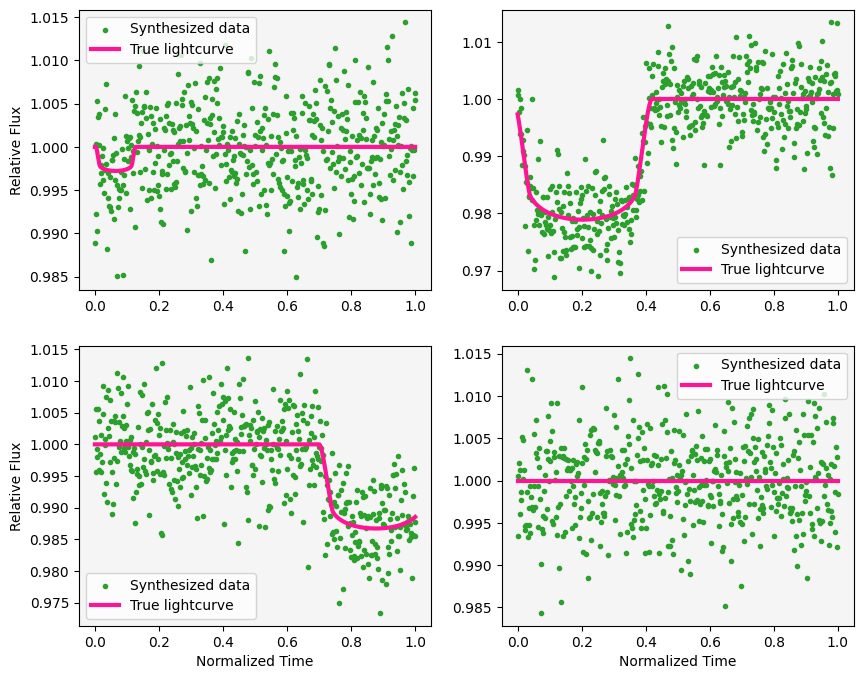

In [6]:
#PLOT EXAMPLES OF THE DATA
plt.style.use('default')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 8))
ax1.set_ylabel("Relative Flux")
ax3.set_ylabel("Relative Flux")
ax3.set_xlabel("Normalized Time")
ax4.set_xlabel("Normalized Time")

ns = [4, 11, 17, 12000]
P1 = ax1.scatter(np.linspace(0, 1, 500), lightcurves[ns[0]]+(1-noise_scale), marker = '.',
                 color = 'tab:green')
P1_true, = ax1.plot(np.linspace(0, 1, 500), true_lightcurves[ns[0]]+(1-noise_scale), color = 'deeppink', lw = 3)
ax1.legend([P1, P1_true], ["Synthesized data", "True lightcurve"])
ax1.set_facecolor('whitesmoke')

P2 = ax2.scatter(np.linspace(0, 1, 500), lightcurves[ns[1]]+(1-noise_scale), marker = '.',
                 color = 'tab:green')
P2_true, = ax2.plot(np.linspace(0, 1, 500), true_lightcurves[ns[1]]+(1-noise_scale), color = 'deeppink', lw = 3)
ax2.legend([P2, P2_true], ["Synthesized data", "True lightcurve"])
ax2.set_facecolor('whitesmoke')

P3 = ax3.scatter(np.linspace(0, 1, 500), lightcurves[ns[2]]+(1-noise_scale), marker = '.',
                 color = 'tab:green')
P3_true, = ax3.plot(np.linspace(0, 1, 500), true_lightcurves[ns[2]]+(1-noise_scale), color = 'deeppink', lw = 3)
ax3.legend([P3, P3_true], ["Synthesized data", "True lightcurve"])
ax3.set_facecolor('whitesmoke')

P4 = ax4.scatter(np.linspace(0, 1, 500), lightcurves[ns[3]]+(1-noise_scale), marker = '.',
                 color = 'tab:green')
P4_true, = ax4.plot(np.linspace(0, 1, 500), true_lightcurves[ns[3]]+(1-noise_scale), color = 'deeppink', lw = 3)
ax4.legend([P4, P4_true], ["Synthesized data", "True lightcurve"])
ax4.set_facecolor('whitesmoke')

plt.show()

In [7]:
# create model
keras.utils.set_random_seed(0)
model = keras.Sequential(
    [
        # 1. ADD HIDDEN LAYERS (WITH ACTIVATION FUNCTIONS)
        layers.Flatten(input_shape=(500,)),
        layers.Dense(128, activation = 'relu'),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(32, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid') # 2. CHANGE THIS LINE TO SPECIFY ACTIVATION FUNCTION
    ]
)

In [8]:
#compile model
model.compile(
    loss = keras.losses.binary_crossentropy, # note that we use a binary loss function this time
    optimizer = keras.optimizers.Adam(learning_rate=0.01), # use Adam optimizer
    metrics =['accuracy'],
)

In [9]:
#split the data into 80/20 train-test splits
x_train, x_test, y_train, y_test = train_test_split(lightcurves, is_transit, test_size = 0.2, random_state = 1)
x_train_true = train_test_split(true_lightcurves, is_transit, test_size = 0.2, random_state = 1)[0]
x_test_true = train_test_split(true_lightcurves, is_transit, test_size = 0.2, random_state = 1)[1]

In [10]:
#train the model
history = model.fit(x_train, y_train, epochs = 10, verbose = 2)

Epoch 1/10
500/500 - 1s - loss: 0.1486 - accuracy: 0.9410 - 1s/epoch - 3ms/step
Epoch 2/10
500/500 - 1s - loss: 0.0862 - accuracy: 0.9723 - 783ms/epoch - 2ms/step
Epoch 3/10
500/500 - 1s - loss: 0.0711 - accuracy: 0.9783 - 786ms/epoch - 2ms/step
Epoch 4/10
500/500 - 1s - loss: 0.0657 - accuracy: 0.9802 - 770ms/epoch - 2ms/step
Epoch 5/10
500/500 - 1s - loss: 0.0601 - accuracy: 0.9820 - 784ms/epoch - 2ms/step
Epoch 6/10
500/500 - 1s - loss: 0.0477 - accuracy: 0.9858 - 781ms/epoch - 2ms/step
Epoch 7/10
500/500 - 1s - loss: 0.0461 - accuracy: 0.9862 - 774ms/epoch - 2ms/step
Epoch 8/10
500/500 - 1s - loss: 0.0401 - accuracy: 0.9881 - 778ms/epoch - 2ms/step
Epoch 9/10
500/500 - 1s - loss: 0.0347 - accuracy: 0.9898 - 770ms/epoch - 2ms/step
Epoch 10/10
500/500 - 1s - loss: 0.0321 - accuracy: 0.9912 - 766ms/epoch - 2ms/step


In [11]:
#Test it on the training data

# generate predictions
y_pred = model.predict(x_test)

# convert probabilities to 0s or 1s
y_pred_binary = [
    1 if prob > 0.5 else 0 for prob in np.ravel(y_pred)
]

125/125 [==============================] - 0s 2ms/step


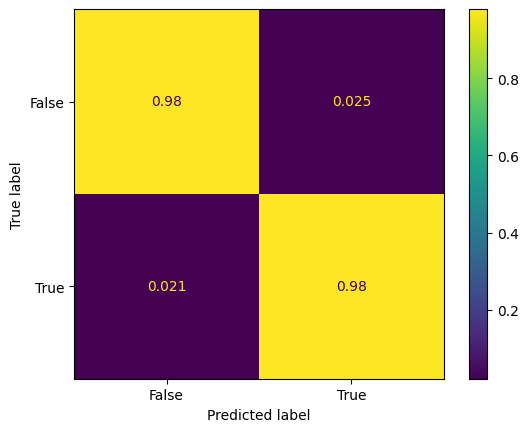

In [12]:
# plot confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_binary, normalize = 'true') # normalized to show proportions

cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()